# MNIST dataset - NN example(Pytorch)
> A tutorial of gradient descent from scratch using pytorch 

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/MNIST.png

In [185]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F


In [8]:
#collapse- output
# this line of code will download the images(60000) in the defined root folder
# download = True - when ran once will nor re-download all the images if it finds the images in the root path
# train = True means it is the training set
dataset = MNIST(root='Deep_Learning_Explorations/data/',train = True, download=True,transform=transforms.ToTensor())

# Dataset is a tuple of image and the label
# indexing the dataset will show us that
# shape of thwe image is 1*28*28
# 28 * 28 are the pixel values ranging from values 0 to 1
# this image has a just one channel as it is  a gray scale image
type(dataset[0][0]), type(dataset[0][1]), dataset[0][0].shape

(torch.Tensor, int, torch.Size([1, 28, 28]))

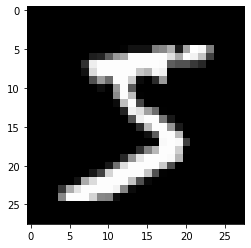

In [7]:
plt.imshow(dataset[0][0], cmap = 'gray');

## Split Dataset - Training and Validation

In [9]:
#collapse-output
# Split the dataset into a training and the validation set
tr_data, val_data = random_split(dataset,[50000,10000])
len(tr_data), len(val_data)

(50000, 10000)

## Training and Validation Dataloader

In [10]:
# Create dataloaders
# Dataloader helps in converting the dataset into batches of data by describing the batch_size
tr_loader = DataLoader(tr_data,batch_size=200,shuffle=True)
val_loader = DataLoader(val_data,batch_size=200)

In [11]:
#collapse-output
# We can see that the data is a batch of 128 images and 120 labels
for data,label in tr_loader:
    print(data.shape)
    print(len(label))
    break

torch.Size([200, 1, 28, 28])
200


In [12]:
#collapse-output
# x@w.t()+ bias - Use the same equation
model = nn.Linear(in_features= 784,out_features=10)

# A model will randomly initialize the parameters(wt's and biases)
model.weight.shape, model.bias.shape

(torch.Size([10, 784]), torch.Size([10]))

In [13]:
#collapse-output
for img,label in tr_loader:
    # shape of the batch in the beggining
    print(img.shape)
    #this functionality can be added inside the model in the forward method
    img = img.reshape(-1,28*28)
    # shape after reshaping into a vector of 784 elements
    print(img.shape)
    # applying the model to the reshaped img
    pred = model(img)
    print(model(img).shape)
    # As we can see that the model has outputted 10 probabilities which is a prob for all elements from 0-9
    break

torch.Size([200, 1, 28, 28])
torch.Size([200, 784])
torch.Size([200, 10])


In [14]:
#collapse-output
print(pred)
pred.shape

tensor([[-0.1780, -0.2030, -0.1832,  ..., -0.0791,  0.1601, -0.0289],
        [-0.0835, -0.3761, -0.2121,  ..., -0.2008, -0.2714, -0.2222],
        [-0.0419, -0.1072, -0.0031,  ..., -0.1503,  0.0071, -0.1969],
        ...,
        [-0.1106, -0.1116,  0.1379,  ..., -0.0675, -0.0677,  0.0206],
        [-0.0918, -0.1213, -0.0014,  ..., -0.1266,  0.1137,  0.3449],
        [-0.2163,  0.0296,  0.0380,  ..., -0.0783, -0.1645, -0.1849]],
       grad_fn=<AddmmBackward0>)


torch.Size([200, 10])

## Additional functionality to our NN model

To add additional functionality to the NN model we need to create a MnistModel class and inheret the nn.Module. 
Addiditional functionality in this is the step of reshaping the batch of data passing through the model to a vector of 784 pixels

In [19]:
# Add additional functionality to the NN model

class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MNIST()

In [20]:
# shape of wts and bias
model.layer.weight.shape, model.layer.bias.shape

(torch.Size([10, 784]), torch.Size([10]))

## Sofmax

Softmax converts a vector of K real numbers into a probability distribution of K possible outcomes

It is basically calculated by taking the exponent of preds and dividing by their sum to make sure its sum is 1


In [21]:
# We can see that the model from the above class works
for dta,label in tr_loader:
    pred = model(dta)
    print(pred.shape)
    print(label.shape)
    break

# We will apply softmax now - which converts the probability b/w 0 and 1 and the sum is 1
torch.sum(F.softmax(pred[0])).item()

# Applying softmax on the whole batch
pred_s = F.softmax(pred,dim=1)

# torch amx function gives us the index of the max probability as well as the probability
index_prob,prob = torch.max(pred_s,dim=1)

index_prob.shape,prob.shape

torch.Size([200, 10])
torch.Size([200])


/var/folders/j4/0sh22ln930vdhyh1wkttl89m0000gp/T/ipykernel_24095/3939508011.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.sum(F.softmax(pred[0])).item()


(torch.Size([200]), torch.Size([200]))

## Accuracy

The predictions are converted into probabilities and the highest probability is calculated using the max function

The index of the highest probability is then compared to the actual label and the accuracy % is calculated by divding the correct predictions with the total images


In [174]:
def metric_acc(out,label):
    index_prob,prob = torch.max(pred_s,dim=1)
    return torch.sum(prob==label)/prob.numel()

# We will get the same value even if we do not apply the softmax as
# e^x is an increasing function, i.e., if y1 > y2, then e^y1 > e^y2. The same holds after averaging out the values to get the softmax.
metric_acc(prob,label)


tensor(0.0700)

In [175]:
# cross entropy -ve log of predicted prob
# loss function will be cross_entropy
loss = F.cross_entropy(pred, label)
print(loss)

tensor(2.3289, grad_fn=<NllLossBackward0>)


## Model Training

This fit function is the training step. This training step invovles training the model on the training dataloader, calculating the loss, calculating the gradient for the
train loader and updating the weights and reseting the gradient at the end.

For the second part of the loop - we validate the model on the validation dataloader. The steps include calculating the loss and accuracy after each epoch and printing them at
the end. We can notice that the loss and the accuracy on the validation set improves after each epoch


In [249]:
def fit(epochs,learning_rate,model,train_loader,val_loader,opt_func=torch.optim.SGD):
    optimizer = torch.optim.SGD(model.parameters(), lr= learning_rate , momentum=0.9)
    out_lst = []
    for epoch in range(epochs):
        
        # Training step on the training dataloader
        for batch in tr_loader:
            #extract batch of images and label
            img,label = batch
            #calculate prediction using the MNISTMODEL class initialized above
            pred = model(img)
            #Since this is a multi-label image classification model- the loss function is cross entropy
            loss = F.cross_entropy(pred,label)
            # In this step we calculate the gradient of the loss function with respect to the parameters or 784 pixels in this case
            loss.backward()
            # In this step we update the weights
            optimizer.step()
            # We make the gradient zero again so that now the gradients are not calculated untill the training is not done
            optimizer.zero_grad()
         
        # Validation on the validation dataloader   
        for batch_val in val_loader:
            img_val,label_val = batch_val
            pred_val = model(img_val)
            # loss is computed
            loss_val = F.cross_entropy(pred_val,label_val)
            # Accuracy is computed
            acc_val = metric_acc(pred_val,label_val)
            out_lst.append({'Epoch':epoch,'val_loss': loss_val, 'val_acc': acc_val})
        
        # Accuracies and loss are stacked together for each epoch, mean is calculated and the results are printed    
        val_loss_epoch = torch.stack([dct['val_loss'] for dct in out_lst]).mean()
        val_acc_epoch = torch.stack([dct['val_acc'] for dct in out_lst]).mean()                  
        print('Epoch: {0}, loss: {1}, accuracy_val: {2}'.format(epoch,val_loss_epoch,val_acc_epoch))

model = MnistModel()

We can clearly see that with each epoch the loss and accuracies improve.
You can try to use different number of epochs and learning rate to see if you can improve the accuracy

In [250]:
#collapse-output
fit(20,learning_rate=0.005,model= model,train_loader = tr_loader,val_loader = val_loader)

Epoch: 0, loss: 0.5632244348526001, accuracy_val: 0.861500084400177
Epoch: 1, loss: 0.5117447376251221, accuracy_val: 0.8712499737739563
Epoch: 2, loss: 0.4806540310382843, accuracy_val: 0.8765000700950623
Epoch: 3, loss: 0.45891621708869934, accuracy_val: 0.8803249597549438
Epoch: 4, loss: 0.44262486696243286, accuracy_val: 0.8833799362182617
Epoch: 5, loss: 0.4297642111778259, accuracy_val: 0.885816752910614
Epoch: 6, loss: 0.4192468225955963, accuracy_val: 0.8878857493400574
Epoch: 7, loss: 0.41042187809944153, accuracy_val: 0.889549970626831
Epoch: 8, loss: 0.4029468595981598, accuracy_val: 0.891033411026001
Epoch: 9, loss: 0.3964667320251465, accuracy_val: 0.8922899961471558
Epoch: 10, loss: 0.3907521069049835, accuracy_val: 0.8933908939361572
Epoch: 11, loss: 0.385611355304718, accuracy_val: 0.8943833708763123
Epoch: 12, loss: 0.38104525208473206, accuracy_val: 0.8952845931053162
Epoch: 13, loss: 0.37690234184265137, accuracy_val: 0.8960857391357422
Epoch: 14, loss: 0.37316834926

## Testing on the test set

In [251]:
img_test = MNIST(root='Deep_Learning_Explorations/data/',train = False,transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 9


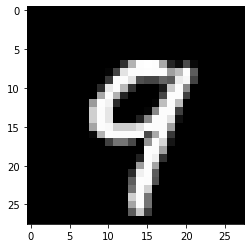

In [252]:
# We can plot the gray scale image using matplotlib and specifying cmap = gray
# gray scale has just 1 channnel
# 1*28*28, 1 here specifies that image has just one channel
img, label = img_test[12]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

## Prediction Function on the test set

In [253]:
def pred_function(img,model):
    img.shape
    inp = img.unsqueeze(0)
    out = model(inp)
    prob , preds = torch.max(out,dim=1)
    return preds[0].item()

Label: 3 , Predicted: 3


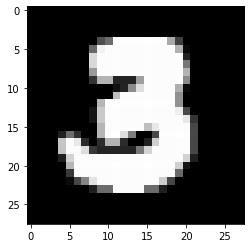

In [256]:
img, label = img_test[200]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', pred_function(img, model))

Label: 6 , Predicted: 6


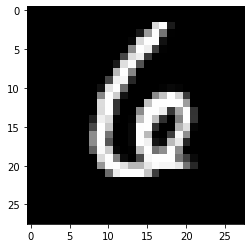

In [255]:
img, label = img_test[123]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', pred_function(img, model))

## Testing on all images - the test set

In [284]:
# define the test set
test_loader = DataLoader(img_test, batch_size=20)

# pass the batches to the model and calculate model accuracy and loss
def test_set_preds(test_loader,model):
    out_lst = []
    for i, batch_val in enumerate(test_loader):
            img_val,label_val = batch_val
            pred_val = model(img_val)
            # loss is computed for that batch
            loss_val = F.cross_entropy(pred_val,label_val)
            # Accuracy is computed for that batch
            acc_val = metric_acc(pred_val,label_val)
            out_lst.append({'val_loss': loss_val, 'val_acc': acc_val})     
    #Accuracies and loss are stacked together for each epoch, mean is calculated and the results are printed    
    final_loss = torch.stack([dct['val_loss'] for dct in out_lst]).mean()
    final_acc= torch.stack([dct['val_acc'] for dct in out_lst]).mean()             
    return 'loss: {0}, accuracy_val: {1}'.format(final_loss,final_acc)

In [285]:
test_set_preds(test_loader,model)

'loss: 0.297660231590271, accuracy_val: 0.9175999164581299'